# CryptoDataPy Demo

`v0.0.1` 

Last Updated: 2022.1.19.22.0`

In this notebook, we will walk through how to use **CryptoDataPy** to query various types of data from multiple sources and get it ready for data analysis. 


## Table of Contents:
- [Quick Start](#quick-start): get ready-for-analysis digital assets data in a few lines of code.
- [Data Catalog](#data-catalog): `DataCatalog` allows you to **explore** what **data** is available and understand it better.
- [Data Request](#data-request): `DataRequest` is used to specify the **parameters values** for the **data request**.
- [Get Data](#get-data): `GetData` **fetches data** specified in the data request.
- [Clean Data](#clean-data): `CleanData` provides **tools for cleaning data** including: removing and repairing outliers, removing assets trading below an average traded value (liquidity threshold), removing observations with long periods of missing values, removing tickers with short price histories (minimum number of observations), and removing specific tickers to be excluded from the analysis (e.g. stablecoins).

# Quick Start <a class="anchor" id="quick-start"></a>

**CryptoDataPy** allows you to create high quality data sets ready for analysis from a variety of sources in 2 stpes with only a few lines of code. 

This saves you time and effort on having to become familiar with each data source's API, file and data response formats, and spending countless hours wrangling and cleaning data.

## Step 1: Data Extraction


Let's start by collecting our data.


First, we need to import `DataRequest`, `GetData` 


In [40]:
import pandas as pd
from matplotlib import pyplot as plt
from cryptodatapy.extract.datarequest import DataRequest
from cryptodatapy.extract.getdata import GetData
import warnings
warnings.filterwarnings("ignore")

Then, specify which data you want with `DataRequest` and fetch the data with `GetData`.

In [41]:
# glassnode
data_req = DataRequest(data_source='glassnode', 
                       tickers=['btc', 'eth'], 
                       fields=['close', 'add_act', 'hashrate'], 
                       freq='d',
                      start_date='2016-01-01')

In [42]:
df = GetData(data_req).get_series()

With same data request parameters, can you retrieve the same data from other sources for comparison.

In [43]:
# coinmetrics
data_req = DataRequest(data_source='coinmetrics', 
                       tickers=['btc', 'eth'], 
                       fields=['close', 'add_act', 'hashrate'], 
                       freq='d',
                      start_date='2016-01-01')
df1 = GetData(data_req).get_series()

In [44]:
# cryptocompare
data_req = DataRequest(data_source='cryptocompare', 
                       tickers=['btc', 'eth'], 
                       fields=['close', 'add_act', 'hashrate'], 
                       freq='d',
                      start_date='2016-01-01')
df2 = GetData(data_req).get_series()

## Step 2: Visual Data Inspection

Next, we can plot the series from various sources to compare them.

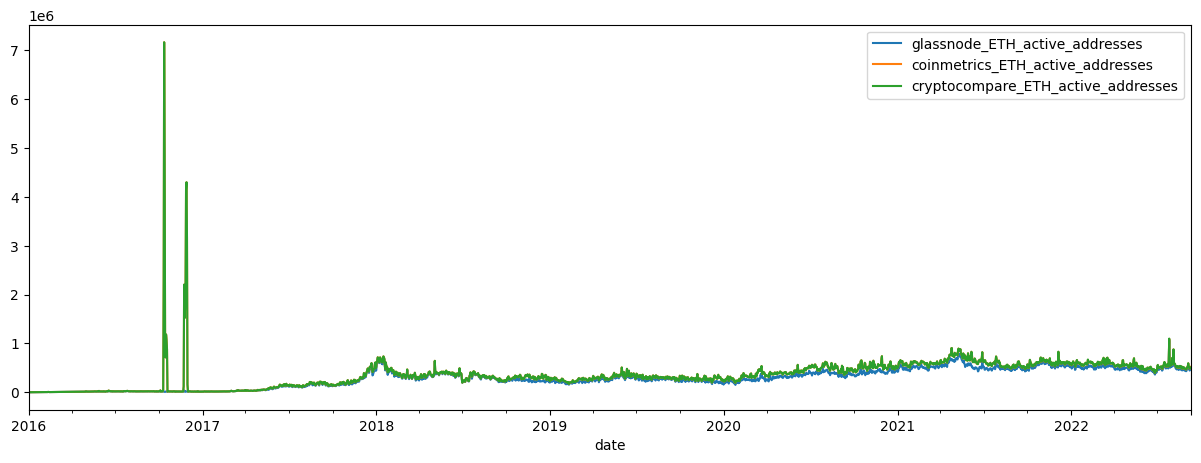

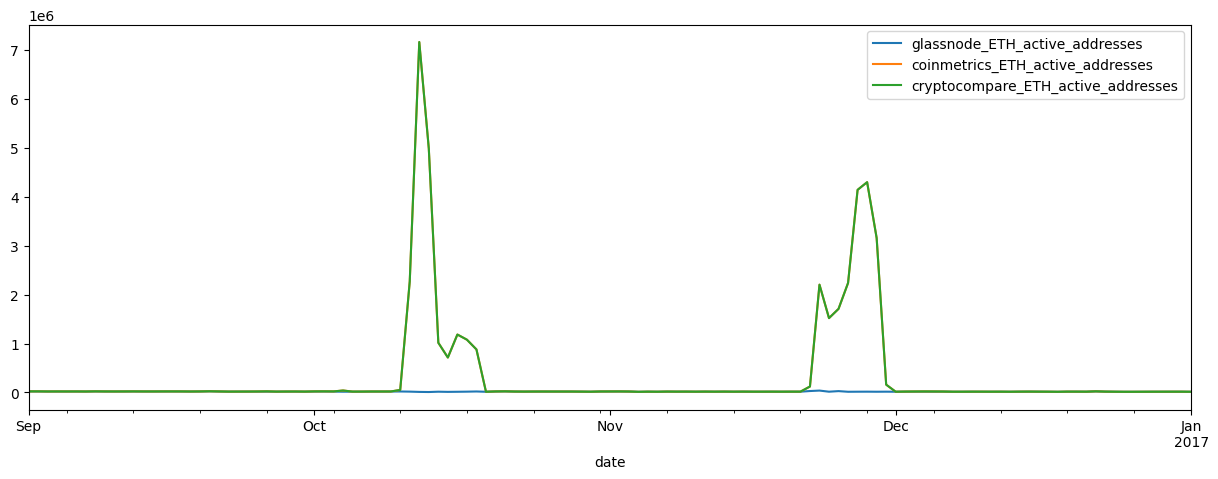

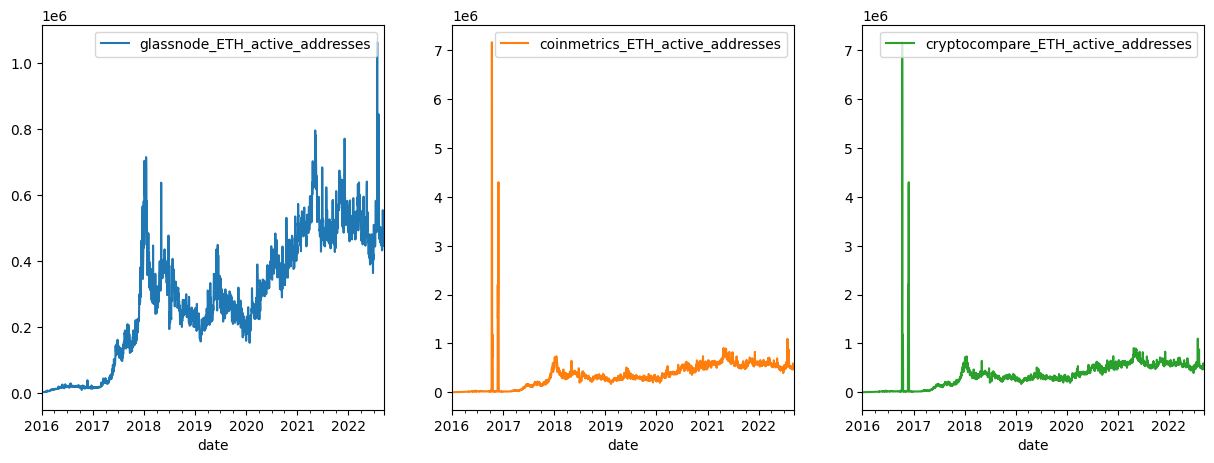

In [45]:
# concat dfs
df3 = pd.concat([df, df1, df2], axis=1)
add_act_df = df3.loc[pd.IndexSlice[:, 'ETH'], 'add_act'].droplevel(1)
# rename cols
col_names = [vendor + '_' + 'ETH_' + 'active_addresses' for vendor in ['glassnode', 'coinmetrics', 'cryptocompare']]
add_act_df.columns = col_names
# plot active addresses
add_act_df.plot(figsize=(15,5))
add_act_df.loc['2016-09-01':'2017-01-01'].plot(figsize=(15,5))
add_act_df.plot(subplots=True, layout=(1,3), figsize=(15,5))
plt.legend(loc='upper right');

Comparing the three active address series, we notice that both the Cryptocompare and Coinmetrics active addresses appear to have **large outliers in ETH active addresses** in late 2016. 

Large outliers can cause major distortions down stream in any machine learning or predictive process so cleaning this data before doing so is a necessary next step.

## Step 3: Data Cleaning

Once outliers are detected through visual data inspection, they can be filtered and repaired by importing **CryptoDataPy**'s `CleanData` module. 

We have several options:

1. **Use the series without large outliers**.
2. **Filter the outliers using one of CryptoDataPy's outlier detection methods** (shown below) and keeping the 'cleaned' series.
3. **Combine 1 and 2**, e.g. filtering and repairing outliers using outlier detection and missing values imputation algorithms, and then taking the median (or some other measure of central tendency) from the resulting series as the representative 'true series'(also shown below).

In [46]:
# import CleanData module
from cryptodatapy.transform.clean import CleanData

Here, we will use the **STL outlier detection algorithm**, similar to the one used by [Twitter](https://blog.twitter.com/engineering/en_us/a/2015/introducing-practical-and-robust-anomaly-detection-in-a-time-series) to filter/remove outliers, and then use the **interpolation method** for repair of bad data/missing values.

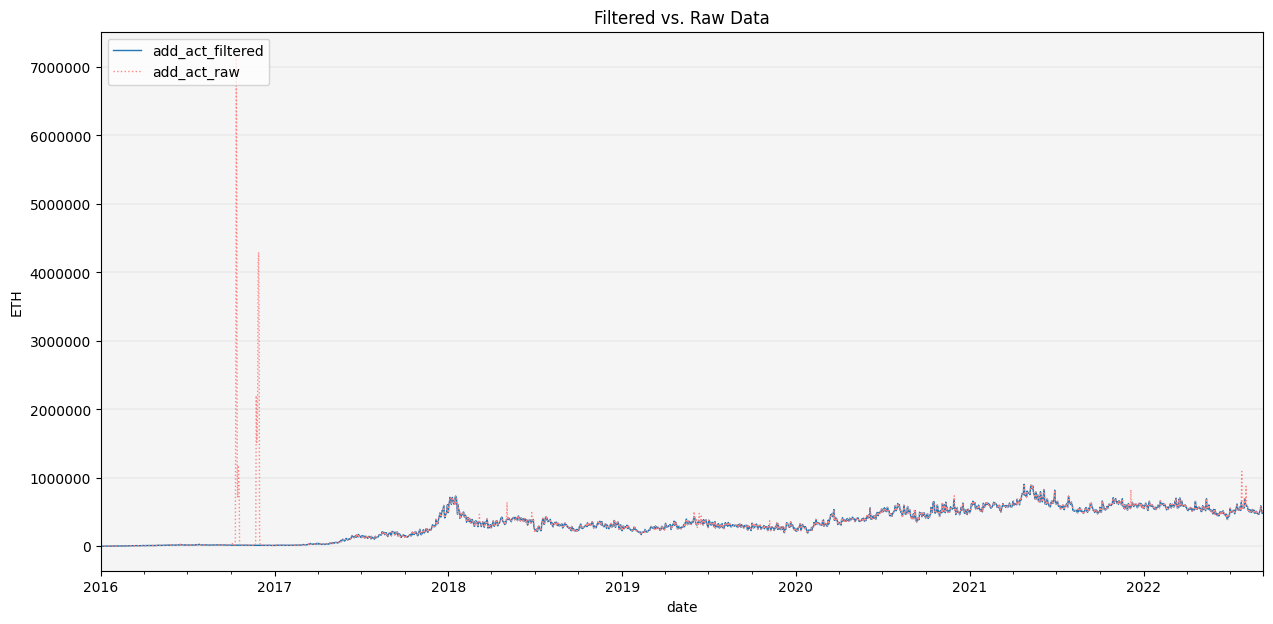

In [47]:
# filter coinmetrics data 
# show raw vs filtered plot
CleanData(df1).filter_outliers(od_method='stl').repair_outliers(imp_method='interpolate').show_plot(plot_series=('ETH', 'add_act'))
# save filtered df
clean_df1 = CleanData(df1).filter_outliers(od_method='stl').repair_outliers(imp_method='interpolate').get(attr='df')

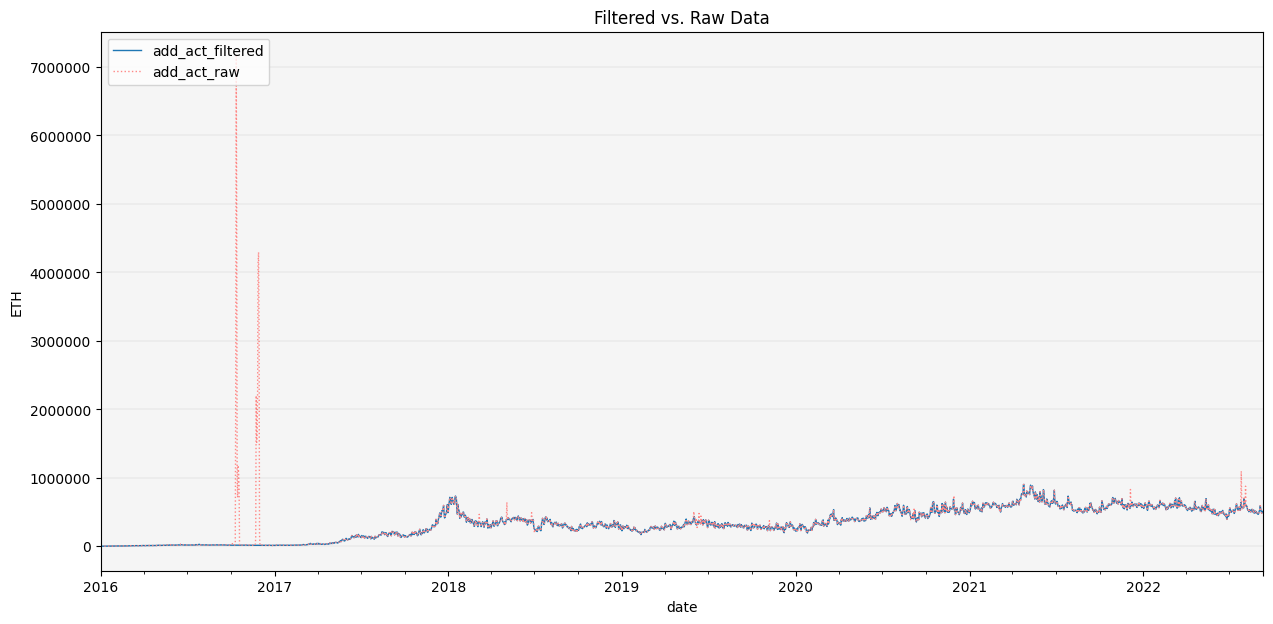

In [48]:
# filter cryptocompare data 
# show raw vs filtered plot
CleanData(df2).filter_outliers(od_method='stl').repair_outliers(imp_method='interpolate').show_plot(plot_series=('ETH', 'add_act'))
# save filtered df
clean_df2 = CleanData(df2).filter_outliers(od_method='stl').repair_outliers(imp_method='interpolate').get(attr='df')

Let's visually inspect the data once again to assess data quality.

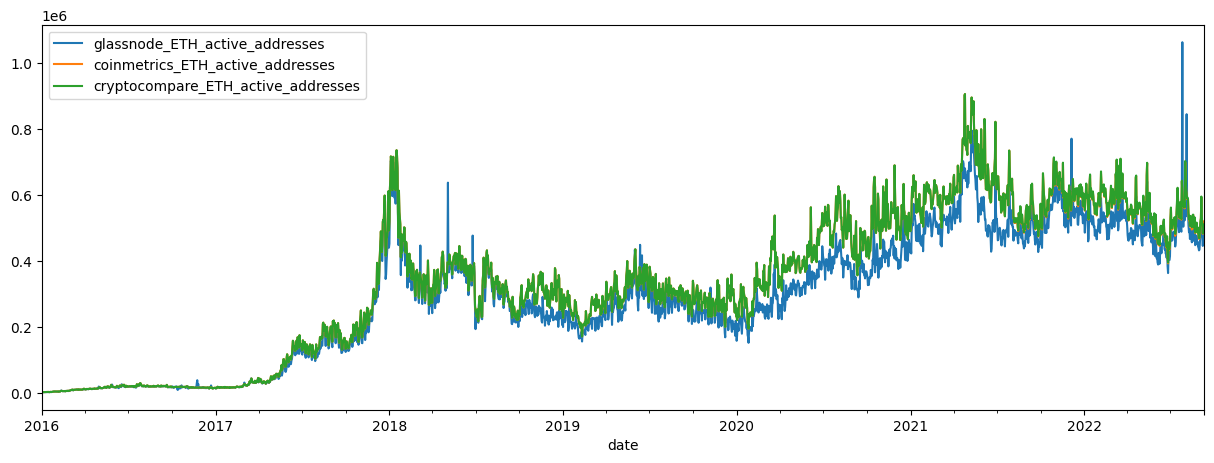

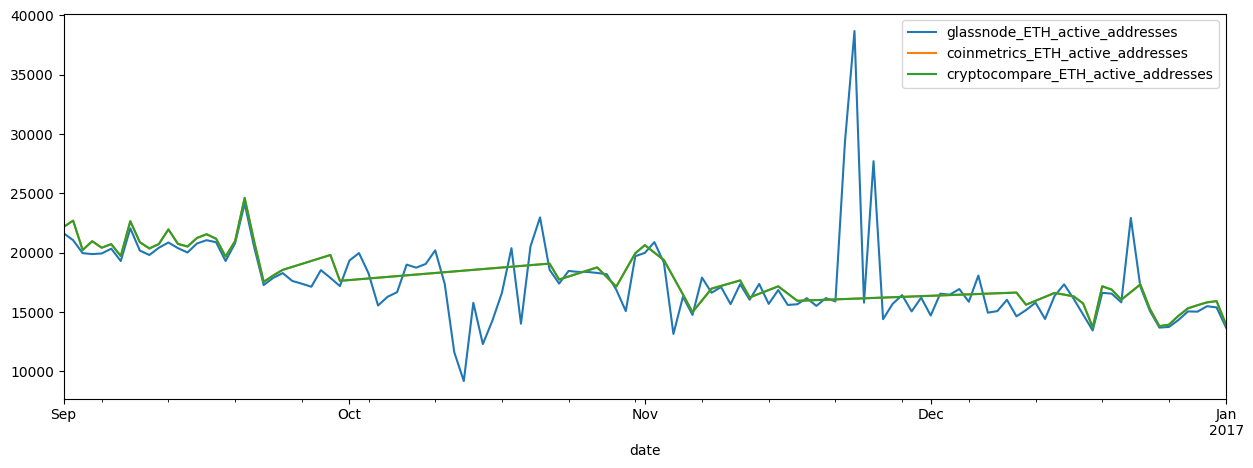

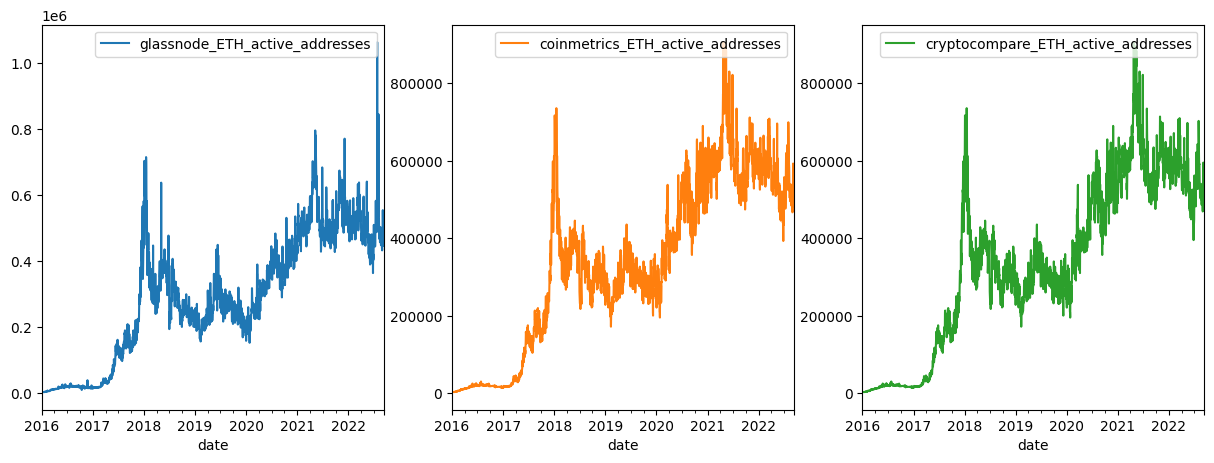

In [49]:
# concat dfs
df_clean = pd.concat([df, clean_df1, clean_df2], axis=1)
add_act_df1 = df_clean.loc[pd.IndexSlice[:, 'ETH'], 'add_act'].droplevel(1)
# rename cols
col_names = [vendor + '_' + 'ETH_' + 'active_addresses' for vendor in ['glassnode', 'coinmetrics', 'cryptocompare']]
add_act_df1.columns = col_names
# plot active addresses
add_act_df1.plot(figsize=(15,5))
add_act_df1.loc['2016-09-01':'2017-01-01'].plot(figsize=(15,5))
add_act_df1.plot(subplots=True, layout=(1,3), figsize=(15,5))
plt.legend(loc='upper right');

These data cleaning algorithms do a good job of filtering and repairing large outliers as we can see.

We can now use one of the 'cleaned' data sets for data analysis, or alternatively, **use all 3 series to construct a 'series of truth'** which uses the median of the 3 time series.

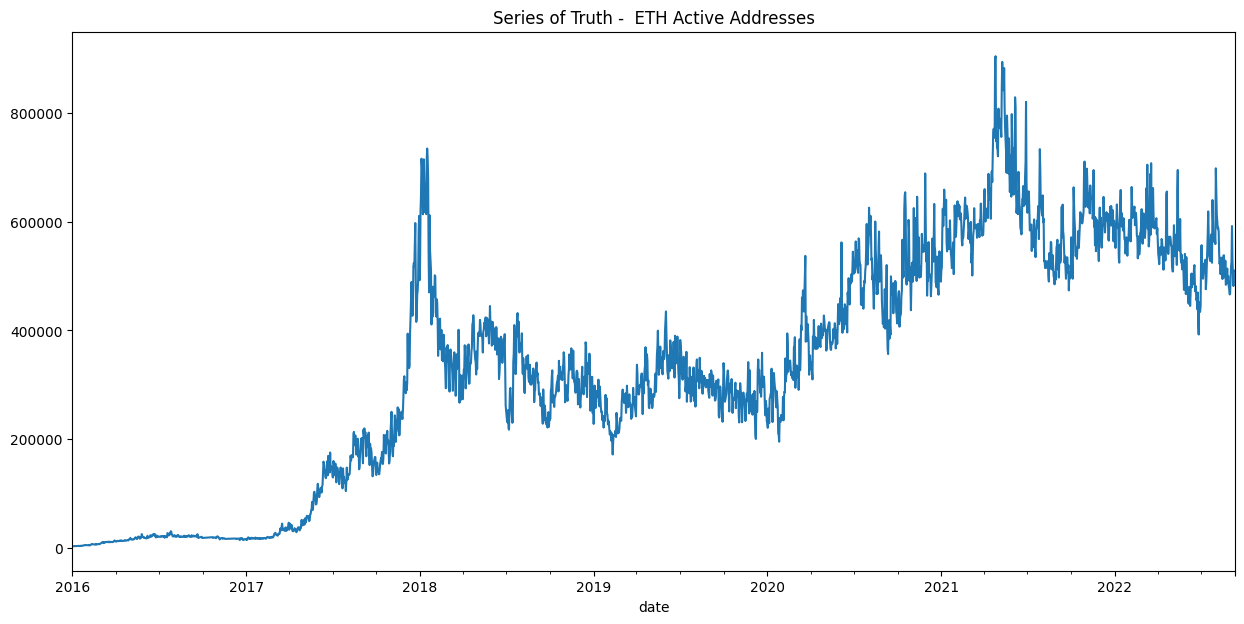

In [50]:
# plot series of truth
df_clean.add_act.median(axis=1).unstack()['ETH'].plot(title='Series of Truth -  ETH Active Addresses', figsize=(15,7));

You are now ready to begin exploring, analyzing and predicting with clean data!

For a deeper dive on how to maximize your use of **CryptoDataPy**, see the Deep Dive section below.

# Deep Dive <a class="anchor" id="deep-dive"></a>

Below we walk-through the key features of the **CryptoDataPy** library.


- **`Data Catalog`**:

    - `data_sources`: the data_sources attribute gets information on all the available data sources. 
    - `get_tickers_metadata`: the get_tickers_metadata method gets information on available tickers. Additional tickers metadata can be obtained for each data source by instantiating the data source object and using the appropriate methods (see Data Sources section).
    - `get_fields_metadata`: the get_fields_metadata method gets information on available fields along with their **CryptoDataPy** identifiers. Additional fields metadata can be obtained for each data source by instantiating the data source object and using the appropriate methods (see Data Sources section).
    - `search_tickers`: the search_tickers method allows you to search for tickers by ticker, country, country id, asset class, etc.
    - `search_fields`: the search_fields method allows you to search for fields by name, id, category, etc. It also provides identifiers for each data source.
    - `scrape_stablecoins`: the scrape_stablecoins method scrapes information on stablecoins from the selected web page/url. This allows us to remove a list of stablecoins when we wish to exclude them for our analysis, or simply work with that list to get data for the analysis of stablecoins.
    
    
- **`Data Requests`**:

    - `Data requests`: an intuitive parameter interface which allows you to specify the query parameters for the data you want.


- **`Get Data`**:

    - `get_meta`: gets metadata from the selected data source by instantiating a data source's object.
    - `get_series`: gets any time series data from the selected data source by instantiating a data source's object and using the `get_data` method. The data is retrieved and wrangled into [tidy data](https://www.jstatsoft.org/article/view/v059i10) format.


- **`Data Sources`**:
    - *Data credentials*: requesting and storing your api keys.
    - *Metadata*: get metadata from data source.


- **`Data Cleaning`**:
    - *Outlier detection*: detecting outliers in raw data.
    - *Repair*: dealing with missing values or outliers in the data. 
    - *Filters*: filtering 'bad data' based on specific criteria (e.g. assets with low liquidity, stablecoins, etc).
    - *Cleaning*: creating a data cleaning pipeline to get data ready for analysis.


# Data Catalog <a class="anchor" id="data-catalog"></a>

The `DataCatalog` allow us to explore what data is available and understand it better.

To access the data catalog, instantiate a DataCatalog object:

In [ ]:
from cryptodatapy.util.datacatalog import DataCatalog 
dc = DataCatalog()

### Data Sources

Available `data sources` 


In [ ]:
dc.data_sources

### Tickers

Available tickers can be accessed with the `get_tickers_metadata` method:

In [ ]:
dc.get_tickers_metadata()

### Fields

Available fields can be accessed with the `get_fields_metadata` method:

In [ ]:
dc.get_fields_metadata()

# Data Vendors

Pulling data from vendors generally requies either becoming familiar with their web APIs (by reviewing their documentation) or installing an API wrapper. 

With `cryptodatapy` you can interact with any supported data vendor's web API and access its data using our intuitive interface. Below, we'll show to access data from various data vendors. 

## Data Credentials

Most data vendors will require an API key to access their data so we must first request and store those API keys. 

We recommend storing API keys, along with all other data credentials, in the DataCredentials dataclass. It acts as a data container which stores all relevant data constants for **CryptoDataPy**. 

In [ ]:
# import DataCredentials to set CryptoCompare API key
from cryptodatapy.util.datacredentials import DataCredentials, set_credential
# uncomment and run line below
# set_credential('cryptocompare_api_key', {'insert your api key here'}) # this only needs to be run once

Once we have obtained and set our API keys, we can import the data vendor's class and initialize an object. 
<br>
If your API key is not set, it will be returned as None from DataCredentials. You should therefore pass it as a parameter in the data vendor's object, as shows below with CryptoCompare.

In [ ]:
# import CryptoCompare
from cryptodatapy.extract.data_vendors.coinmetrics_api import CoinMetrics
# initialize CryptoCompare
cm = CoinMetrics() # if api key set using set_credential in datacredentials.py
# else insert your cryptocompare api key, uncomment and run the code below
# cc = CryptoCompare(api_key={your cryptocompare api key})

Now, we can explore some of the available data...

## Metadata

`cryptodatapy`'s interface makes it easy to explore any data vendor's available data. Let's explore CryptoCompare as an example. 

### Categories

Categories are either assets classes or types of time series data (e.g. macro, alt data, etc.).

To get a data vendor's available categories

In [ ]:
cm.categories

### Assets

To get a list of available assets

In [ ]:
cm.assets

For more granular asset info, use the get_asset_info() method

In [ ]:
cm.get_assets_info()

To get top market cap assets

In [ ]:
cc.get_top_market_cap_assets()

### Indexes

To get a list of available indexes

In [ ]:
cc.indexes

For more granular index info

In [ ]:
cc.get_indexes_info()

### Markets
To get a list of availalble markets (asset:quote_ccy)

In [ ]:
cc.markets

For more granular markets info

In [ ]:
cc.get_markets_info()

### Market Types
 
To get a list of available market types

In [ ]:
cc.market_types

### Fields
To get a list of available fields

In [ ]:
cc.fields

To get on chain asset info

In [ ]:
cc.get_onchain_info()

### Frequencies

To get a list of available data (observations) frequencies

In [ ]:
cc.frequencies

### Exchanges
To get a list of available exchanges

In [ ]:
cc.exchanges

For more granular exchanges info

In [ ]:
cc.get_exchanges_info()

### News
To get recent news

In [ ]:
cc.get_news()

To get news sources

In [ ]:
cc.get_news_sources()

### Base URL
To get the API's base url

In [ ]:
cc.base_url

### Maximum Observations per Call
To get the maximum observations (rows) per API call

In [ ]:
cc.max_obs_per_call

### Rate Limit
To get the number of API calls made and remaining

In [ ]:
cc.rate_limit

# Data Request <a class="anchor" id="data-request"></a>

Now that we know what data is available, we can create a data request which will be sent to the data vendor's API. 

To do this, we must first import the DataRequest class and initialize a DataRequest Object with the parameters for the data we want.

In [ ]:
# import DataRequest
from cryptodatapy.data_requests.datarequest import DataRequest
# initialize DataRequest
data_req = DataRequest(tickers=['btc', 'eth'], fields=['close', 'active_addresses'])

We specify the desired tickers and fields in our data request. Start and end dates, as well as data frequency, are set to defaults when not specified (i.e. earliest start date, latest end date and daily frequency).

For more details on data request parameters, see `datarequest` in our documentation API reference.

## Get Data

Once the parameters of our data request are set, `cryptodatapy` automatically converts those parameters to the data vendor's format saving you from spending time studying each vendor's API documentation.

Each data vendor provides a range of time series data which we can access with the **fetch_datatype** methods.

To get OHLCV data, we can use the **fetch_ohlcv()** method

In [ ]:
cc.fetch_ohlcv(data_req)

To get indexes data, we can use the **fetch_indeces()** method and any avaiable index ticker(s)

In [ ]:
cc.fetch_indexes(DataRequest(tickers='mvda'))

To get on-chain data, we can use the **fetch_onchain()** method

In [ ]:
cc.fetch_onchain(data_req)

To get social stats data, we can use the **fetch_social()** method

In [ ]:
cc.fetch_social(data_req)

Finally, to get any data type, we can use the **fetch_data()** method

In [ ]:
cc.fetch_data(data_req)